In [1]:
import os
import glob
import obspy
import time
import pandas as pd
from obspy.taup import TauPyModel
from obspy.clients.iris import Client
client = Client()
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
ddir = f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow"
data_sac = f"{ddir}/Download/SAC"
wdir = f"{ddir}/Download/Verified"

20220212232629910


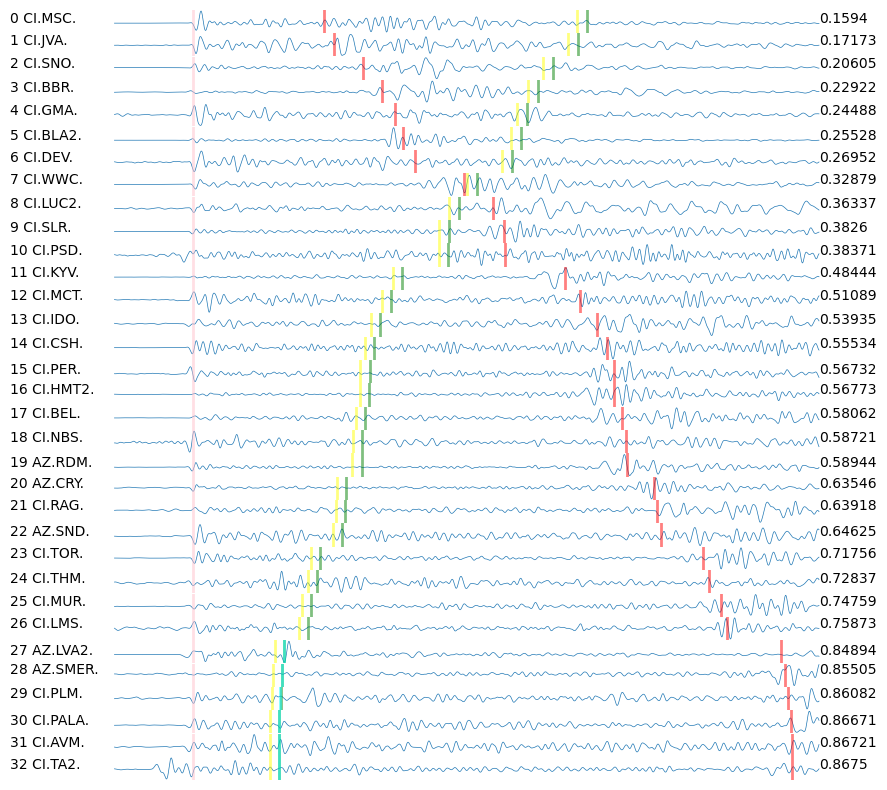

KeyboardInterrupt: Interrupted by user

In [3]:
file = open("./progression-8.5.info", "r")
evt = file.read()
file.close()
switch1 = True
model = TauPyModel(f"hk.npz")

tb= -1.5
ta = 12



ascale =1
events = os.listdir(data_sac)
for ev in events:
    
    if ev != evt and switch1 == True:
            continue
    switch1 = False
    fig = plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.1,hspace=0.01)
    file = open("./progression-8.5.info", "w")
    file.write(f"{ev}")
    file.close()
    
    try:
        handpickP = pd.read_csv(f'{data_sac}/{ev}/judge/handpickP.info',delim_whitespace=True,names=["evt","sta", "Tp","TsPmP","TsPn"], header = None)
    except: 
        print("no handpickP for event: {}".format(ev))
        continue
    evdp = []
    rdist = []

    
    
    print(ev)
    for i,sta in enumerate(handpickP["sta"]):
        st = obspy.read(f"{data_sac}/{ev}/{sta}*Z.SAC.bp")
        sachd = st[0].stats.sac
        evdp = np.append(evdp, sachd["evdp"])
        distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
        gcarc = distaz['distance']
        rdist = np.append(rdist, gcarc)
        #print(st[0])
    
    handpickP["evdp"] = evdp
    handpickP["rdist"] = rdist
    handpickP.sort_values(by=['rdist'], inplace = True)
    handpickP = handpickP.reset_index(drop=True)
    #print(handpickP)
    
    for i,sta in enumerate(handpickP["sta"]):
        if i == 0:
            st = obspy.read(f"{data_sac}/{ev}/{sta}*Z.SAC.bp")
        else:
            st += obspy.read(f"{data_sac}/{ev}/{sta}*Z.SAC.bp")
    
    t = np.arange(tb, ta, st[0].stats.delta)
    #print(handpickP)
    #print(st)
    TS_array = []
    for i, trace in enumerate(st):
        #print(trace)
        ax = fig.add_subplot(len(st), 1, i+1)
        Tp = handpickP["Tp"][i]
        shift1 = trace.stats.sac.b
        shift2 = trace.stats.sac.o
        shift3 = (Tp+shift2)
        #print(shift3)
        
        w1 = int((tb-shift1+shift3)/trace.stats.delta) 
        w2 = int((ta-shift1+shift3)/trace.stats.delta)
        
        ax.plot(t,ascale*trace.data[w1:w2]/np.max(np.abs(trace.data[w1:w2])),linewidth=0.5)
        ax.text(tb-2, 0, "{} {}".format(i, handpickP["sta"][i]))
        ax.text(ta, 0, "{}".format(handpickP["rdist"][i]))
        plt.axvline(x= 0, color="pink", alpha=0.5, linewidth=2)
        
        sdep = handpickP["evdp"][i]
        radist = handpickP["rdist"][i]
        arrival_PvmP = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=radist, phase_list=['PvmP'])
        TPvmP = arrival_PvmP[0].time +shift2
        plt.axvline(x= TPvmP, color="yellow", alpha=0.5, linewidth=2)
        
        arrival_S = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=radist, phase_list=['s', 'S'])
        TS = arrival_S[0].time +shift2
        plt.axvline(x= TS, color="red", alpha=0.5, linewidth=2)
        Ts_save = f"{arrival_S[0].time:.3g}"
        TS_array = np.append(TS_array, Ts_save)
        
        TsPmP = handpickP["TsPmP"][i]+shift2
        plt.axvline(x= TsPmP, color="green", alpha=0.5, linewidth=2)
        TsPn = handpickP["TsPn"][i]
        if TsPn != "nan":
            TsPn = handpickP["TsPn"][i]+shift2
            plt.axvline(x= TsPn, color="cyan", alpha=0.5, linewidth=2)
    #plt.tight_layout()
    
        ax.axis('off')
    handpickP["Ts"] = TS_array
    #plt.tight_layout()
    plt.show()
    quality = input("save or skip")
    if quality != 'skip':
        saves = [int(x) for x in quality.split()]
        print(saves)
        handpickP = handpickP.iloc[saves].reset_index(drop=True)
        file = open("judge/combined.txt", "a")
        
        for i, row in handpickP.iterrows():
            #print(index)
            event = handpickP["evt"][i]
            station = handpickP["sta"][i]
            Tp = handpickP["Tp"][i]
            TsPmP = handpickP["TsPmP"][i]
            TsPn = handpickP["TsPn"][i]
            Ts = handpickP["Ts"][i]
            file.write("{} {} {} {} {} {}\n".format(event, station, Tp, TsPmP, TsPn, Ts))
        file.close()
    plt.close()
    clear_output(wait=True)
    
    